In [1]:
%load_ext nb_black
import numpy as np
import pandas as pd
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics as m
import xgboost as xgb
import seaborn as sns
from imblearn.over_sampling import SMOTE  # doctest: +NORMALIZE_WHITESPACE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from collections import Counter

from collections import Counter
from numpy.random import RandomState
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTENC


warnings.filterwarnings("ignore")
random_seed = 8

Using TensorFlow backend.


<IPython.core.display.Javascript object>

In [2]:
data1 = pd.read_csv("../NextYearData_actualData_train.txt")
data2 = pd.read_csv("../ThisYearData_actualData_train.txt")
data3 = pd.read_csv("../ThisYearData_actualData_test.txt")

data4 = pd.read_csv("../NextYearData_actualData_test.txt")
data5 = pd.read_csv("../Predicted_NextYearData.txt")

<IPython.core.display.Javascript object>

In [3]:
data = pd.read_csv("../../sep19SexAndAgeAddedFINAL DATASET_ver2.txt")

# filter the data set
data = data[data.FIELD_16 != 1]  # exclude people who are diagnosed for (diabetes)
data = data[data.FIELD_23 != 1]  # exclude people who are on medication for diabetes

data = data[
    data.FIELD_15 != 1
]  # exclude people who are diagnosed for (high blood pressure)
data = data[
    data.FIELD_22 != 1
]  # exclude people who are on medication for high blood pressure

data = data[data.FIELD_17 != 1]  # exclude people who are diagnosed for hyperlipidemia
data = data[
    data.FIELD_24 != 1
]  # exclude people who are on medication for hyperlipidemia


conditions = [
    (data.L100800 < 100),
    (data.L100800 >= 100) & (data.L100800 < 126),
    (data.L100800 >= 126),
]
choices = [0, 1, 2]
data["CLASS"] = np.select(conditions, choices, default=0)

<IPython.core.display.Javascript object>

In [4]:
maindata = data.copy()

maindata = maindata[
    [
        "FIELD_1",
        "FIELD_2",
        "L104600",
        "L103000",
        "S000300",
        "L101700",
        "L100700",
        "FIELD_33",
        "FIELD_38",
        "FIELD_40",
        "FIELD_31",
        "SEX",
        "AGE",
        "L100800",
        "CLASS",
    ]
]
maindata["index"] = maindata.index
print(maindata.shape)

(466680, 16)


<IPython.core.display.Javascript object>

In [5]:
# exclude data points which are going to be used for trainig

print(data4.shape)

temp = pd.merge(
    maindata[["index", "FIELD_1", "FIELD_2"]],
    data4[["FIELD_1", "FIELD_2"]],
    how="inner",
    left_on=["FIELD_1", "FIELD_2"],
    right_on=["FIELD_1", "FIELD_2"],
)

print(temp.shape)

maindata = maindata.drop(temp["index"])
maindata.shape

(12458, 16)
(12092, 3)


(454588, 16)

<IPython.core.display.Javascript object>

In [6]:
maindata = maindata.dropna()
print(maindata.shape)

(130632, 16)


<IPython.core.display.Javascript object>

In [7]:
maindata.groupby(by="CLASS").size()

CLASS
0    95662
1    32739
2     2231
dtype: int64

<IPython.core.display.Javascript object>

In [8]:
diabetic = maindata[maindata.CLASS == 2]
preddiabetic = maindata[maindata.CLASS == 1].sample(10000, random_state=42)
normal = maindata[maindata.CLASS == 0].sample(10000, random_state=42)
trainpd = pd.concat([diabetic, preddiabetic, normal])

x = trainpd[
    [
        "L104600",
        "L103000",
        "S000300",
        "L101700",
        "L100700",
        "FIELD_33",
        "FIELD_38",
        "FIELD_40",
        "FIELD_31",
        "SEX",
        "AGE",
    ]
]

y = trainpd[["CLASS"]]

<IPython.core.display.Javascript object>

In [9]:
maindata.to_csv("training_set.txt", sep=",")

<IPython.core.display.Javascript object>

In [10]:
d = data4[data4.CLASS == 2]
_pd = data4[data4.CLASS == 1].sample(d.shape[0], random_state=42)
n = data4[data4.CLASS == 0].sample(d.shape[0], random_state=42)


testpd = pd.concat([d, _pd, n])

print(d.shape, _pd.shape, n.shape)

xtest = testpd[
    [
        "L104600",
        "L103000",
        "S000300",
        "L101700",
        "L100700",
        "FIELD_33",
        "FIELD_38",
        "FIELD_40",
        "FIELD_31",
        "SEX",
        "AGE",
    ]
]
ytest = testpd.CLASS

(236, 16) (236, 16) (236, 16)


<IPython.core.display.Javascript object>

In [11]:
# generate synthetic dataset to overcome class imbalance

sm = SMOTENC(random_state=42, categorical_features=[5, 6, 7, 8])
X_res, y_res = sm.fit_resample(x, y)
print("Resampled dataset samples per class {}".format(Counter(y_res)))

Resampled dataset samples per class Counter({2: 10000, 1: 10000, 0: 10000})


<IPython.core.display.Javascript object>

In [12]:
temp = pd.DataFrame(X_res)
temp.columns = x.columns
temp["CLASS"] = y_res
temp.tail()

,L104600,L103000,S000300,L101700,L100700,FIELD_33,FIELD_38,FIELD_40,FIELD_31,SEX,AGE,CLASS
29995,6.794957,166.036652,26.902443,59.530543,3.856720,2.0,2.0,0.0,0.0,0.0,46.481674,2
29996,7.548710,345.330811,26.070456,57.237375,5.789900,1.0,3.0,3.0,0.0,0.0,50.050501,2
29997,6.052311,47.459136,16.946018,13.934409,3.293441,1.0,1.0,0.0,0.0,1.0,43.196773,2
29998,6.227596,161.000000,23.103716,19.230480,4.594920,1.0,0.0,0.0,0.0,1.0,53.820320,2
29999,6.578945,105.087072,23.226388,26.174144,5.382586,1.0,0.0,4.0,0.0,0.0,58.630608,2


<IPython.core.display.Javascript object>

In [13]:
temp.to_csv("g_training_set.txt", sep=",")

<IPython.core.display.Javascript object>

In [14]:
temp.shape

(30000, 12)

<IPython.core.display.Javascript object>

In [15]:
gx = temp[
    [
        "L104600",
        "L103000",
        "S000300",
        "L101700",
        "L100700",
        "FIELD_33",
        "FIELD_38",
        "FIELD_40",
        "FIELD_31",
        "SEX",
        "AGE",
    ]
]
gy = temp.CLASS

<IPython.core.display.Javascript object>

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    random_state=42,
    n_estimators=300,
    max_depth=4,
    min_samples_split=2,
    min_samples_leaf=5,
    max_features="auto",
)
rf.fit(gx, gy)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

<IPython.core.display.Javascript object>

0.690677966101695


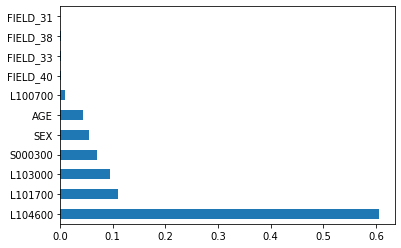

Index(['L104600', 'L101700', 'L103000', 'S000300', 'SEX', 'AGE', 'L100700',
       'FIELD_40', 'FIELD_33', 'FIELD_38', 'FIELD_31'],
      dtype='object')


<IPython.core.display.Javascript object>

In [17]:
from matplotlib import pyplot as plt

ypred = rf.predict(xtest)

score = rf.score(xtest, ytest)
print(score)

feat_importances = pd.Series(rf.feature_importances_, index=xtest.columns)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(16).index)

In [20]:
print("Accuracy on training set: {:.3f}".format(rf.score(gx, gy)))
print("Accuracy on test set: {:.3f}".format(rf.score(xtest, ytest)))

confmatrx = pd.DataFrame(m.confusion_matrix(ytest, ypred))
confmatrx.head()

Accuracy on training set: 0.724
Accuracy on test set: 0.691


,0,1,2
0,151,84,1
1,61,156,19
2,0,54,182


<IPython.core.display.Javascript object>

In [19]:
from sklearn.metrics import classification_report

print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.71      0.64      0.67       236
           1       0.53      0.66      0.59       236
           2       0.90      0.77      0.83       236

    accuracy                           0.69       708
   macro avg       0.71      0.69      0.70       708
weighted avg       0.71      0.69      0.70       708



<IPython.core.display.Javascript object>